## IMPORTS


In [16]:
import numpy as np
import pandas as pd
import os, datetime
import tensorflow as tf
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import *
from tensorflow.keras.optimizers import *
print('Tensorflow version: {}'.format(tf.__version__))

import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

import warnings
warnings.filterwarnings('ignore')


Tensorflow version: 2.10.1


## Hyperparameters

In [17]:
batch_size = 8
seq_len = 5
learning_rate=0.001


## Load  data

In [18]:
import yfinance as yf
from datetime import datetime, timedelta

def download_stock_data(ticker, years_back):
    end_date = datetime(2023, 12, 31)
    start_date = end_date - timedelta(days=years_back * 365)

    data = yf.download(ticker, start=start_date, end=end_date)
    return data

# Example Usage
ticker = 'AAPL'  # Replace with the desired ticker symbol
years_back = 3
historical_data = download_stock_data(ticker, years_back)
df = historical_data[['Open', 'High', 'Low', 'Close', 'Volume']].copy()
# Replace 0 to avoid dividing by 0 later on
df['Volume'].replace(to_replace=0, method='ffill', inplace=True) 
df.sort_values('Date', inplace=True)
df.tail()

[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Volume
Date,,,,,
2023-12-22,195.179993,195.410004,192.970001,193.600006,37122800
2023-12-26,193.610001,193.889999,192.830002,193.050003,28919300
2023-12-27,192.490005,193.500000,191.089996,193.149994,48087700
2023-12-28,194.139999,194.660004,193.169998,193.580002,34049900
2023-12-29,193.899994,194.399994,191.729996,192.529999,42628800


## Plot daily closing prices and volume

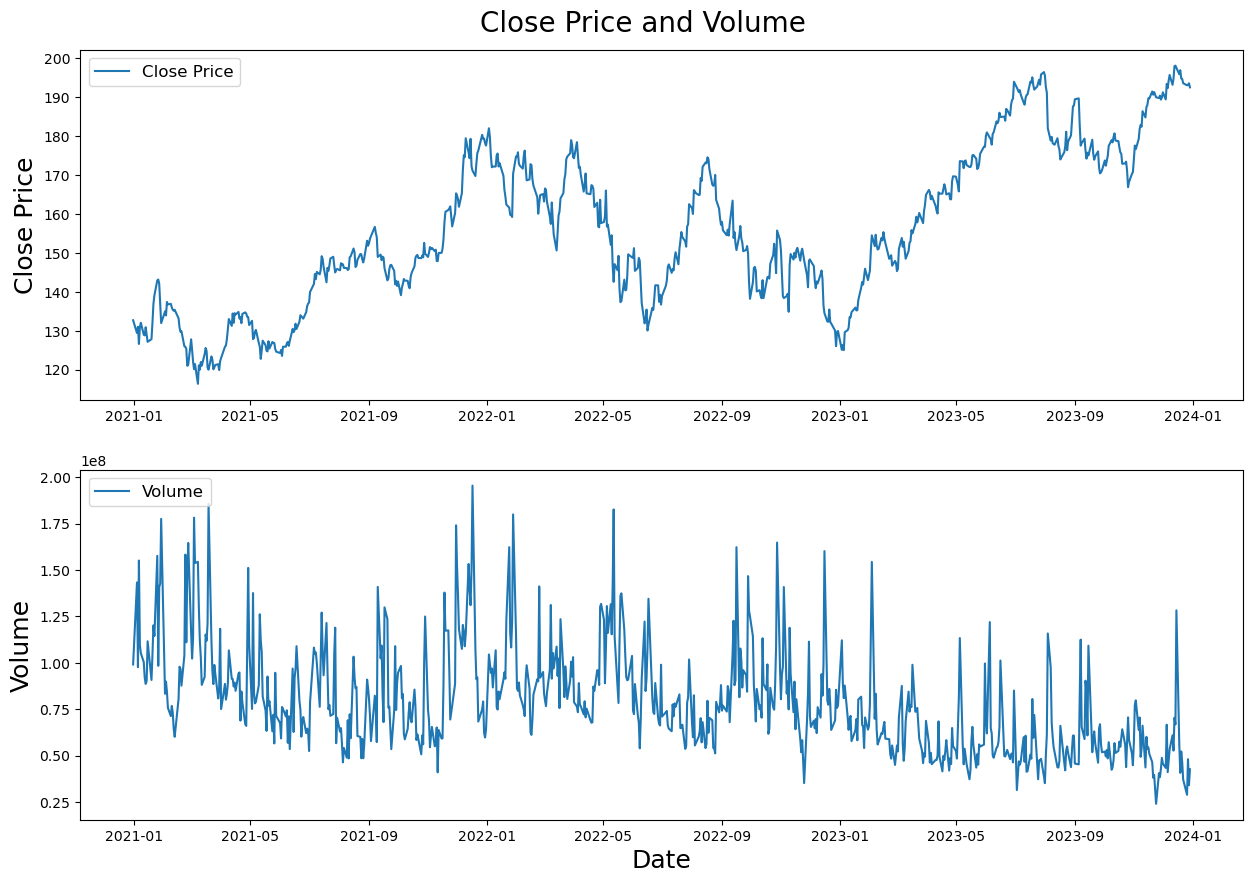

In [19]:


fig = plt.figure(figsize=(15, 10))
st = fig.suptitle("Close Price and Volume", fontsize=20)
st.set_y(0.92)

ax1 = fig.add_subplot(211)
ax1.plot(df.index, df['Close'], label='Close Price')
ax1.set_ylabel('Close Price', fontsize=18)
ax1.legend(loc="upper left", fontsize=12)

ax2 = fig.add_subplot(212)
ax2.plot(df.index, df['Volume'], label='Volume')
ax2.set_xlabel('Date', fontsize=18)  # Etiquetar el eje x con 'Date'
ax2.set_ylabel('Volume', fontsize=18)
ax2.legend(loc="upper left", fontsize=12)

plt.show()


## Split and normalize

In [20]:
'''Create indexes to split dataset'''

times = sorted(df.index.values)
last_10pct = sorted(df.index.values)[-int(0.1*len(times))] # Last 10% of series
last_30pct = sorted(df.index.values)[-int(0.3*len(times))] # Last 30% of series

'''Split the data'''

df_train = df[df.index < last_30pct]  # Training data are 70% of total data
df_val = df[(df.index >= last_30pct) & (df.index < last_10pct)]
df_test = df[df.index >= last_10pct]

# Crear un diccionario para almacenar los normalizadores de cada columna
column_scalers = {}

# Recorrer todas las columnas del DataFrame para ajustar los normalizadores solo con los datos de entrenamiento
for column in df.columns:
    scaler = MinMaxScaler()
    # Ajustar el escalador solo con los datos de entrenamiento
    scaler.fit(df_train[[column]])
    
    # Transformar los datos de entrenamiento, validación y prueba
    df_train[column] = scaler.transform(df_train[[column]])
    df_val[column] = scaler.transform(df_val[[column]])
    df_test[column] = scaler.transform(df_test[[column]])
    
    # Guardar el escalador en el diccionario
    column_scalers[column] = scaler

# Convert pandas columns into arrays
train_data = df_train.values
val_data = df_val.values
test_data = df_test.values

print('Training data shape: {}'.format(train_data.shape))
print('Validation data shape: {}'.format(val_data.shape))
print('Test data shape: {}'.format(test_data.shape))

Training data shape: (528, 5)
Validation data shape: (151, 5)
Test data shape: (75, 5)


## Plot daily changes of close prices and volume

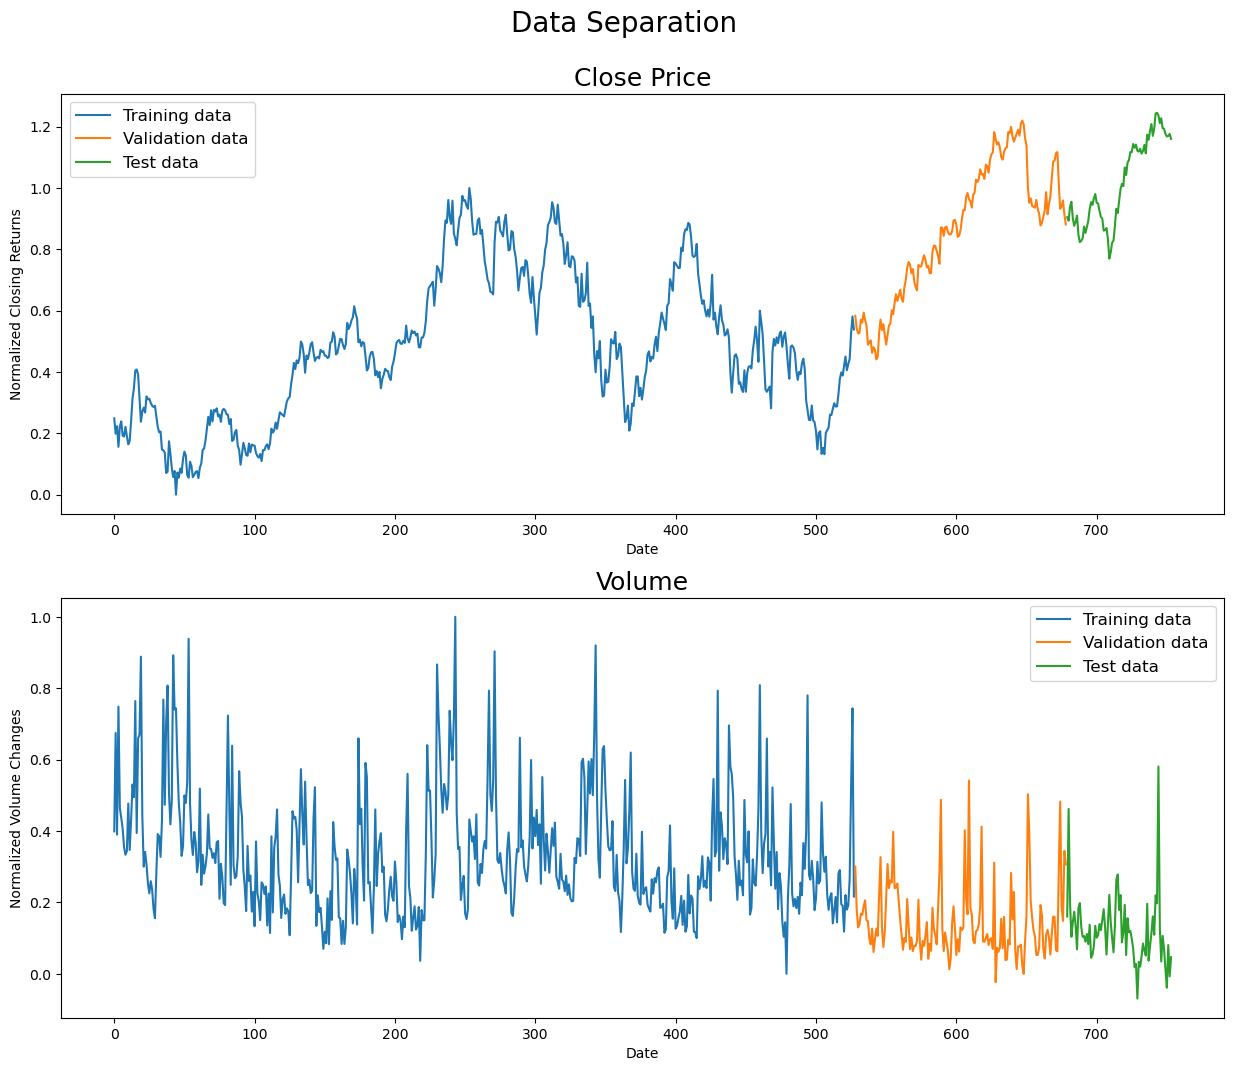

In [21]:
fig = plt.figure(figsize=(15,12))
st = fig.suptitle("Data Separation", fontsize=20)
st.set_y(0.95)

###############################################################################

ax1 = fig.add_subplot(211)
ax1.plot(np.arange(train_data.shape[0]), df_train['Close'], label='Training data')

ax1.plot(np.arange(train_data.shape[0], 
                   train_data.shape[0]+val_data.shape[0]), df_val['Close'], label='Validation data')

ax1.plot(np.arange(train_data.shape[0]+val_data.shape[0], 
                   train_data.shape[0]+val_data.shape[0]+test_data.shape[0]), df_test['Close'], label='Test data')
ax1.set_xlabel('Date')
ax1.set_ylabel('Normalized Closing Returns')
ax1.set_title("Close Price", fontsize=18)
ax1.legend(loc="best", fontsize=12)

###############################################################################

ax2 = fig.add_subplot(212)
ax2.plot(np.arange(train_data.shape[0]), df_train['Volume'], label='Training data')

ax2.plot(np.arange(train_data.shape[0], 
                   train_data.shape[0]+val_data.shape[0]), df_val['Volume'], label='Validation data')

ax2.plot(np.arange(train_data.shape[0]+val_data.shape[0], 
                   train_data.shape[0]+val_data.shape[0]+test_data.shape[0]), df_test['Volume'], label='Test data')
ax2.set_xlabel('Date')
ax2.set_ylabel('Normalized Volume Changes')
ax2.set_title("Volume", fontsize=18)
ax2.legend(loc="best", fontsize=12)

## Create chunks of training, validation and test data

In [22]:
# Training data
X_train, y_train = [], []
for i in range(seq_len, len(train_data)):
  X_train.append(train_data[i-seq_len:i]) # Chunks of training data with a length of 128 df-rows
  y_train.append(train_data[:, 3][i]) #Value of 4th column (Close Price) of df-row 128+1
X_train, y_train = np.array(X_train), np.array(y_train)

###############################################################################

# Validation data
X_val, y_val = [], []
for i in range(seq_len, len(val_data)):
    X_val.append(val_data[i-seq_len:i])
    y_val.append(val_data[:, 3][i])
X_val, y_val = np.array(X_val), np.array(y_val)

###############################################################################

# Test data
X_test, y_test = [], []
for i in range(seq_len, len(test_data)):
    X_test.append(test_data[i-seq_len:i])
    y_test.append(test_data[:, 3][i])    
X_test, y_test = np.array(X_test), np.array(y_test)

print('Training set shape', X_train.shape, y_train.shape)
print('Validation set shape', X_val.shape, y_val.shape)
print('Testing set shape' ,X_test.shape, y_test.shape)

Training set shape (523, 5, 5) (523,)
Validation set shape (146, 5, 5) (146,)
Testing set shape (70, 5, 5) (70,)


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_3 (LSTM)               (None, 5, 150)            93600     
                                                                 
 dropout_3 (Dropout)         (None, 5, 150)            0         
                                                                 
 lstm_4 (LSTM)               (None, 5, 150)            180600    
                                                                 
 dropout_4 (Dropout)         (None, 5, 150)            0         
                                                                 
 lstm_5 (LSTM)               (None, 150)               180600    
                                                                 
 dropout_5 (Dropout)         (None, 150)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                

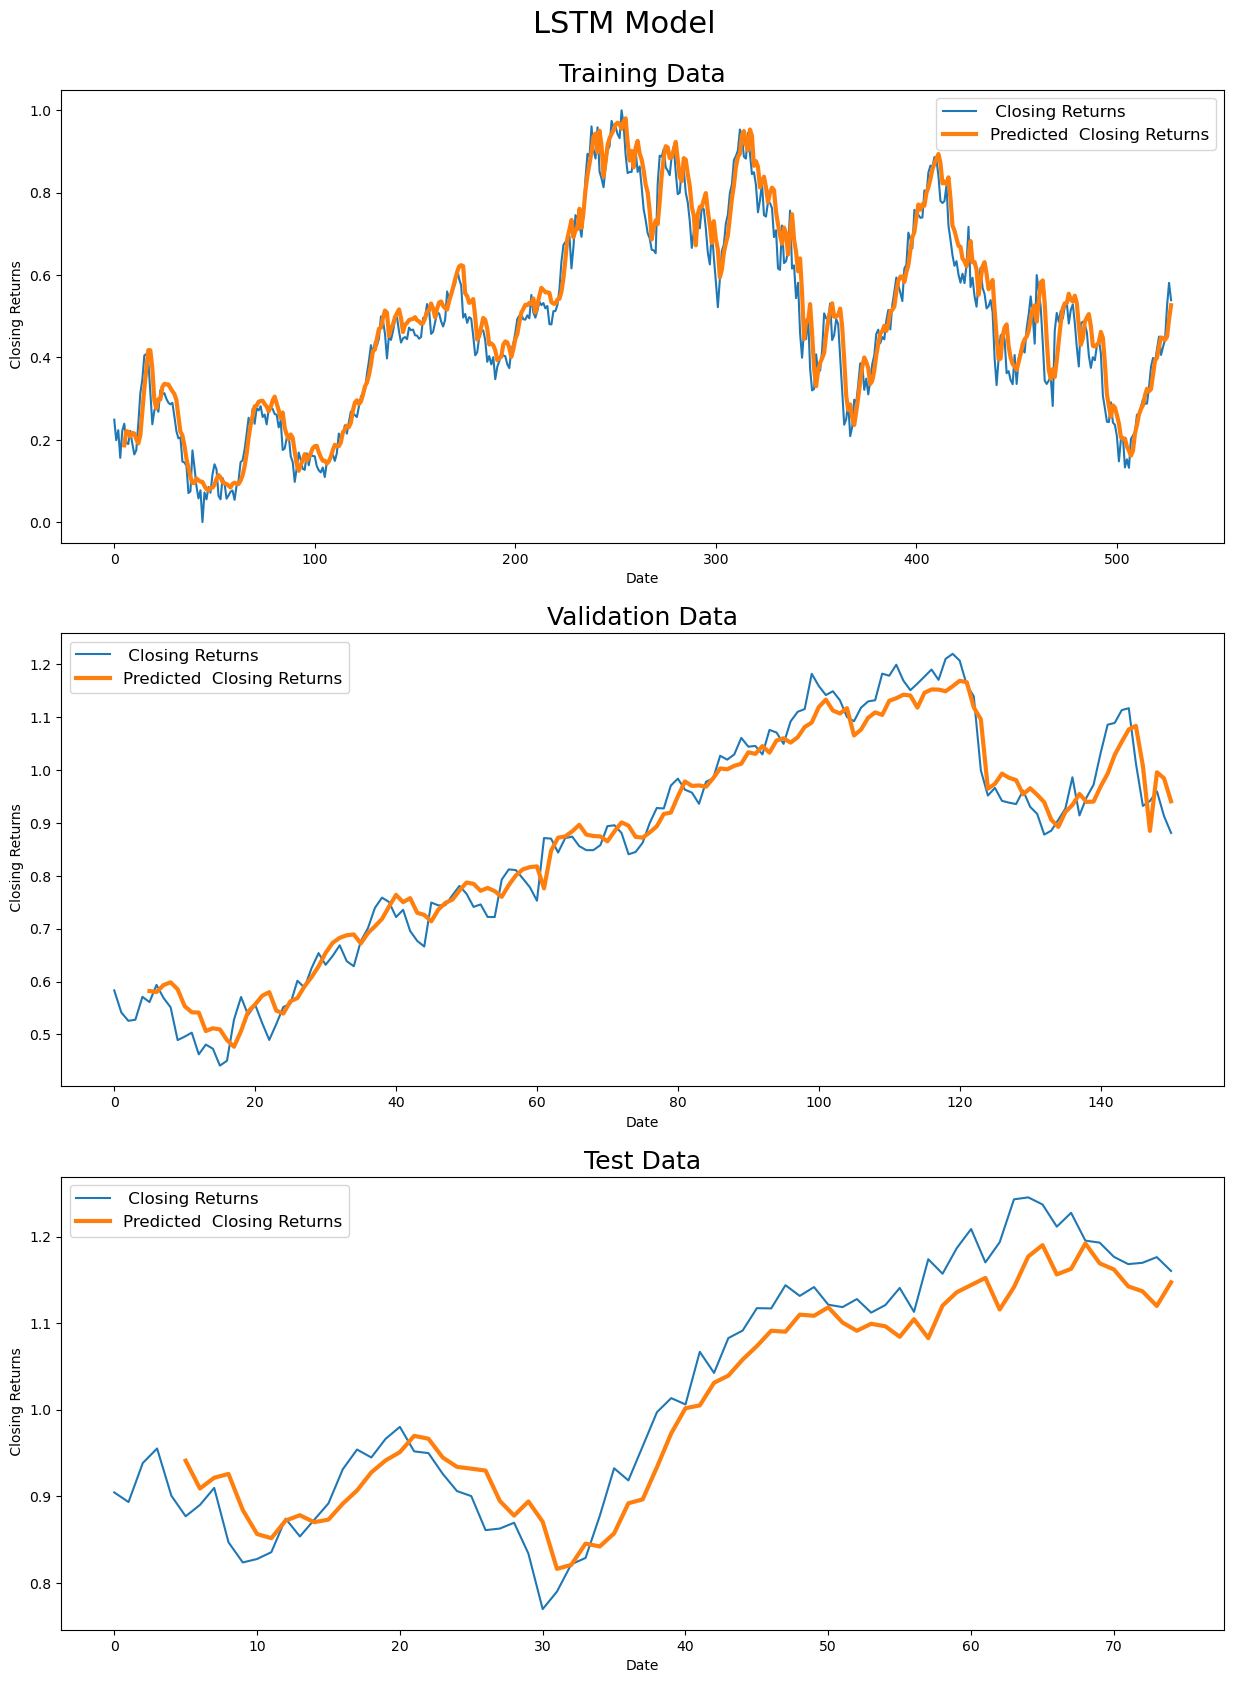

In [23]:
# Define the LSTM model
model = Sequential()
model.add(LSTM(150, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2]), activation='relu'))
model.add(Dropout(0.2))
model.add(LSTM(150, return_sequences=True, activation='relu'))
model.add(Dropout(0.2))
model.add(LSTM(150, activation='relu',))
model.add(Dropout(0.2))
model.add(Dense(1, activation='linear'))  # Capa de salida




# Early Stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)
print(model.summary())
# Inicializar ReduceLROnPlateau
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.9, patience=10, min_lr=0.0005, verbose=1)

# Compilar el modelo
model.compile(optimizer=Adam(learning_rate=learning_rate), loss='mse', metrics=['mae', 'mape'])

# Entrenar el modelo con el callback de ReduceLROnPlateau
history = model.fit(
    X_train, y_train,
    epochs=100,
    batch_size=batch_size,
    validation_data=(X_val, y_val),
    callbacks=[early_stopping, reduce_lr]  
)

###############################################################################
'''Calculate predictions and metrics'''

#Calculate predication for training, validation and test data
train_pred = model.predict(X_train)
val_pred = model.predict(X_val)
test_pred = model.predict(X_test)

#Print evaluation metrics for all datasets
train_eval = model.evaluate(X_train, y_train, verbose=0)
val_eval = model.evaluate(X_val, y_val, verbose=0)
test_eval = model.evaluate(X_test, y_test, verbose=0)
print(' ')
print('Evaluation metrics')
print('Training Data - Loss: {:.4f}, MAE: {:.4f}, MAPE: {:.4f}'.format(train_eval[0], train_eval[1], train_eval[2]))
print('Validation Data - Loss: {:.4f}, MAE: {:.4f}, MAPE: {:.4f}'.format(val_eval[0], val_eval[1], val_eval[2]))
print('Test Data - Loss: {:.4f}, MAE: {:.4f}, MAPE: {:.4f}'.format(test_eval[0], test_eval[1], test_eval[2]))

###############################################################################
'''Display results'''

fig = plt.figure(figsize=(15,20))
st = fig.suptitle("LSTM Model", fontsize=22)
st.set_y(0.92)

#Plot training data results
ax11 = fig.add_subplot(311)
ax11.plot(train_data[:, 3], label=' Closing Returns')
ax11.plot(np.arange(seq_len, train_pred.shape[0]+seq_len), train_pred, linewidth=3, label='Predicted  Closing Returns')
ax11.set_title("Training Data", fontsize=18)
ax11.set_xlabel('Date')
ax11.set_ylabel(' Closing Returns')
ax11.legend(loc="best", fontsize=12)

#Plot validation data results
ax21 = fig.add_subplot(312)
ax21.plot(val_data[:, 3], label=' Closing Returns')
ax21.plot(np.arange(seq_len, val_pred.shape[0]+seq_len), val_pred, linewidth=3, label='Predicted  Closing Returns')
ax21.set_title("Validation Data", fontsize=18)
ax21.set_xlabel('Date')
ax21.set_ylabel(' Closing Returns')
ax21.legend(loc="best", fontsize=12)

#Plot test data results
ax31 = fig.add_subplot(313)
ax31.plot(test_data[:, 3], label=' Closing Returns')
ax31.plot(np.arange(seq_len, test_pred.shape[0]+seq_len), test_pred, linewidth=3, label='Predicted  Closing Returns')
ax31.set_title("Test Data", fontsize=18)
ax31.set_xlabel('Date')
ax31.set_ylabel(' Closing Returns')
ax31.legend(loc="best", fontsize=12)

## Model metrics

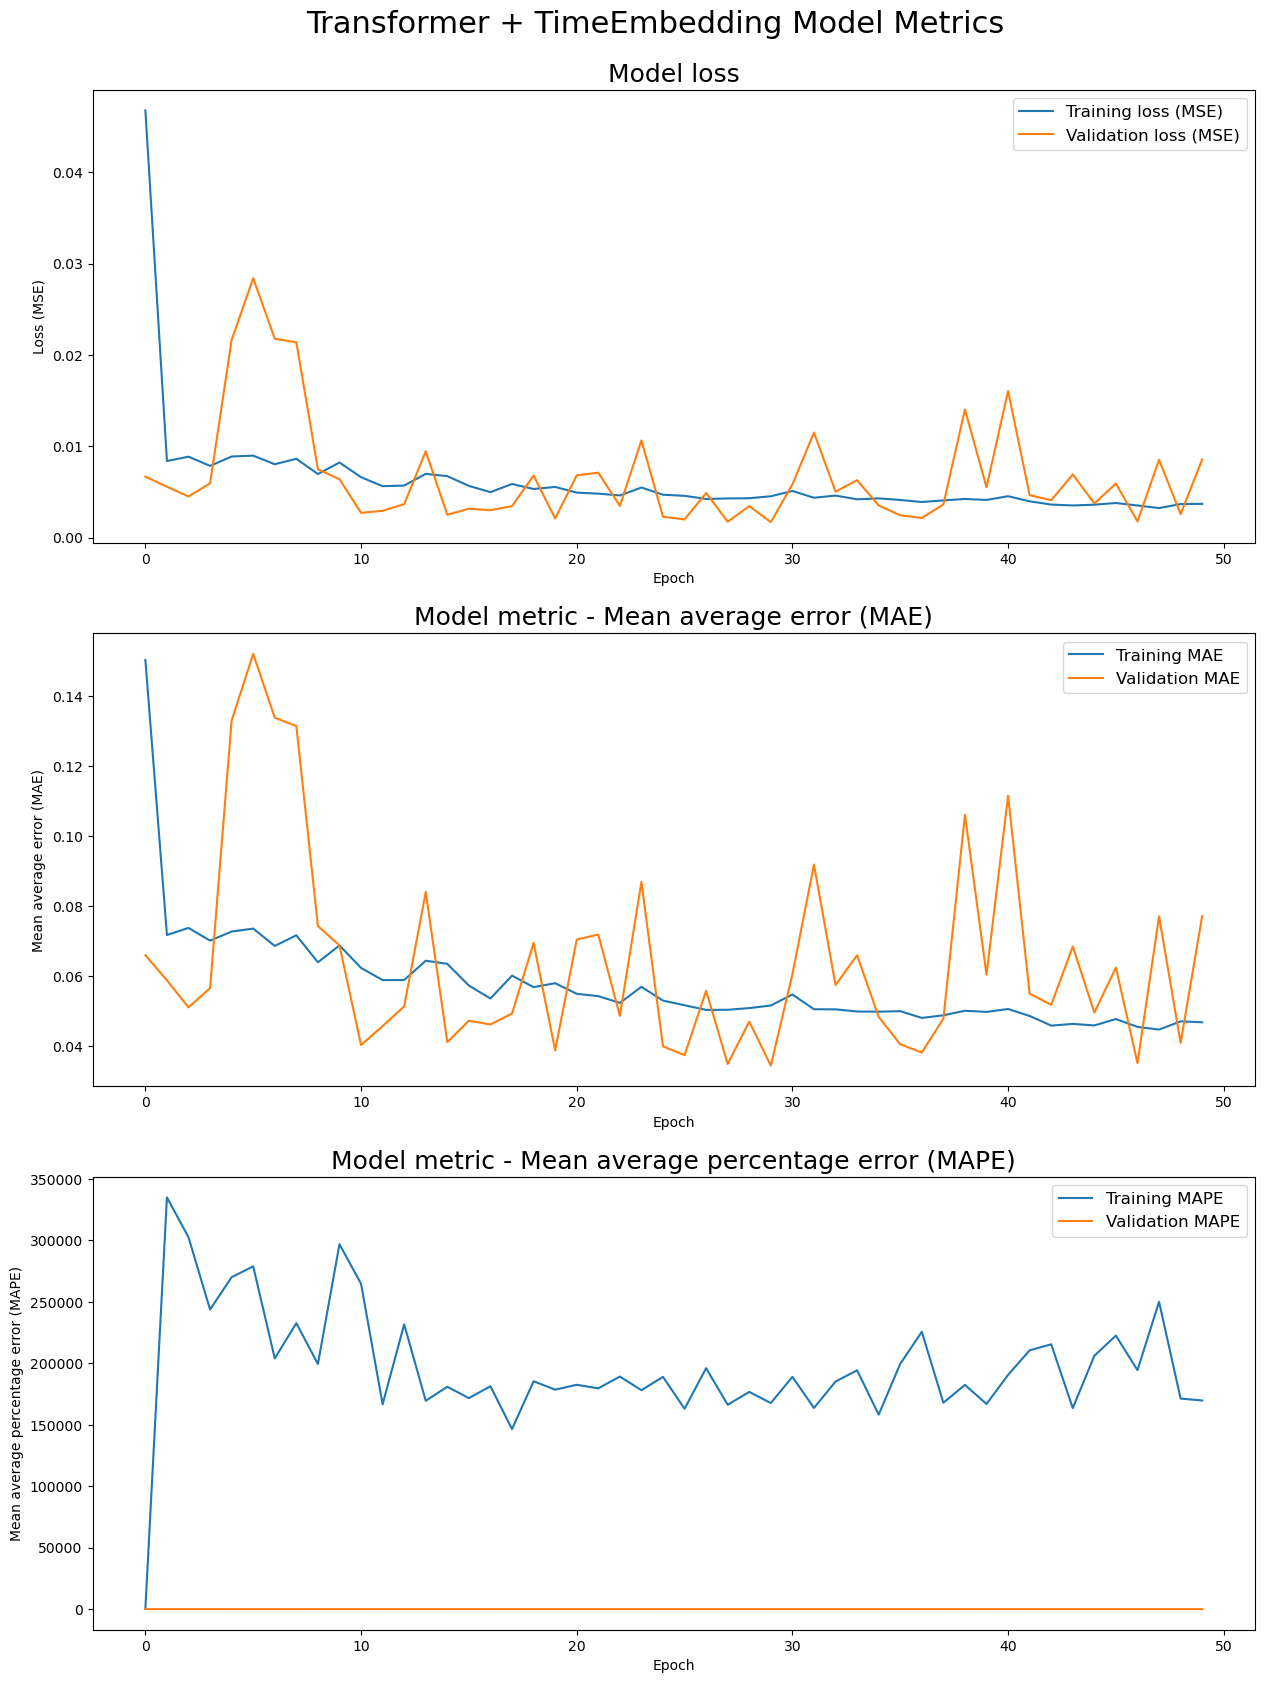

In [24]:
'''Display model metrics'''

fig = plt.figure(figsize=(15,20))
st = fig.suptitle("Transformer + TimeEmbedding Model Metrics", fontsize=22)
st.set_y(0.92)

#Plot model loss
ax1 = fig.add_subplot(311)
ax1.plot(history.history['loss'], label='Training loss (MSE)')
ax1.plot(history.history['val_loss'], label='Validation loss (MSE)')
ax1.set_title("Model loss", fontsize=18)
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss (MSE)')
ax1.legend(loc="best", fontsize=12)

#Plot MAE
ax2 = fig.add_subplot(312)
ax2.plot(history.history['mae'], label='Training MAE')
ax2.plot(history.history['val_mae'], label='Validation MAE')
ax2.set_title("Model metric - Mean average error (MAE)", fontsize=18)
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Mean average error (MAE)')
ax2.legend(loc="best", fontsize=12)

#Plot MAPE
ax3 = fig.add_subplot(313)
ax3.plot(history.history['mape'], label='Training MAPE')
ax3.plot(history.history['val_mape'], label='Validation MAPE')
ax3.set_title("Model metric - Mean average percentage error (MAPE)", fontsize=18)
ax3.set_xlabel('Epoch')
ax3.set_ylabel('Mean average percentage error (MAPE)')
ax3.legend(loc="best", fontsize=12)

In [25]:
print(test_pred)

[[0.94114053]
 [0.90899026]
 [0.9214228 ]
 [0.92582065]
 [0.8842265 ]
 [0.8564328 ]
 [0.85163945]
 [0.8719847 ]
 [0.8781269 ]
 [0.8700992 ]
 [0.8730924 ]
 [0.8914168 ]
 [0.9067385 ]
 [0.927635  ]
 [0.94142663]
 [0.95102715]
 [0.9698081 ]
 [0.9664955 ]
 [0.94482064]
 [0.9339815 ]
 [0.9319174 ]
 [0.92970955]
 [0.8946128 ]
 [0.8776969 ]
 [0.8940477 ]
 [0.8706093 ]
 [0.8162308 ]
 [0.8207812 ]
 [0.84534097]
 [0.8420751 ]
 [0.85714555]
 [0.8919358 ]
 [0.89642966]
 [0.93363047]
 [0.9727113 ]
 [1.0017443 ]
 [1.0049865 ]
 [1.0311328 ]
 [1.0393844 ]
 [1.0578724 ]
 [1.0735097 ]
 [1.0911937 ]
 [1.0900582 ]
 [1.109805  ]
 [1.1084933 ]
 [1.1182704 ]
 [1.1006104 ]
 [1.0911758 ]
 [1.0992408 ]
 [1.0963182 ]
 [1.0842036 ]
 [1.1045169 ]
 [1.0827216 ]
 [1.1202422 ]
 [1.1357082 ]
 [1.1439991 ]
 [1.152196  ]
 [1.1157345 ]
 [1.141548  ]
 [1.1769416 ]
 [1.1900812 ]
 [1.1562618 ]
 [1.1626952 ]
 [1.1920108 ]
 [1.1691002 ]
 [1.1619155 ]
 [1.1424967 ]
 [1.1367673 ]
 [1.1198102 ]
 [1.1471801 ]]


In [26]:
predicted_prices_original_scale = column_scalers['Close'].inverse_transform(test_pred.reshape(-1, 1))
print(predicted_prices_original_scale)

[[178.14587]
 [176.03522]
 [176.8514 ]
 [177.14012]
 [174.40947]
 [172.58481]
 [172.27013]
 [173.60579]
 [174.00902]
 [173.48201]
 [173.67851]
 [174.8815 ]
 [175.88737]
 [177.25923]
 [178.16466]
 [178.79492]
 [180.0279 ]
 [179.81042]
 [178.38747]
 [177.67587]
 [177.54037]
 [177.39543]
 [175.09132]
 [173.9808 ]
 [175.05423]
 [173.51549]
 [169.94554]
 [170.24428]
 [171.85663]
 [171.64223]
 [172.63159]
 [174.91559]
 [175.2106 ]
 [177.65283]
 [180.21849]
 [182.12451]
 [182.33736]
 [184.05386]
 [184.59558]
 [185.80933]
 [186.8359 ]
 [187.99686]
 [187.92232]
 [189.2187 ]
 [189.13258]
 [189.77444]
 [188.61507]
 [187.99568]
 [188.52515]
 [188.33328]
 [187.53796]
 [188.87154]
 [187.44067]
 [189.9039 ]
 [190.91925]
 [191.46353]
 [192.00166]
 [189.60797]
 [191.30263]
 [193.6262 ]
 [194.48883]
 [192.26859]
 [192.69093]
 [194.61551]
 [193.11142]
 [192.63974]
 [191.36491]
 [190.98877]
 [189.87553]
 [191.67236]]


In [27]:
last_rows = historical_data.iloc[-len(predicted_prices_original_scale):]

# Crear un DataFrame con los precios predichos
df_predicted = pd.DataFrame(predicted_prices_original_scale, columns=['Predicted_Close'])

# Asegurarse de que el índice de df_predicted coincida con el de last_rows
df_predicted.index = last_rows.index

# Concatenar la columna 'Close' de historical_data con los precios predichos
result_df = pd.concat([last_rows['Close'], df_predicted], axis=1)

# Ahora result_df contiene los últimos registros de 'Close' y los precios predichos
print(result_df)


                 Close  Predicted_Close
Date                                   
2023-09-21  173.929993       178.145874
2023-09-22  174.789993       176.035217
2023-09-25  176.080002       176.851395
2023-09-26  171.960007       177.140121
2023-09-27  170.429993       174.409470
...                ...              ...
2023-12-22  193.600006       192.639740
2023-12-26  193.050003       191.364914
2023-12-27  193.149994       190.988770
2023-12-28  193.580002       189.875534
2023-12-29  192.529999       191.672363

[70 rows x 2 columns]


In [28]:
from sklearn.metrics import mean_squared_error, mean_absolute_error,mean_absolute_percentage_error

# Calcula el error cuadrático medio (MSE)
mse = mean_squared_error(result_df['Close'], result_df['Predicted_Close'])
print(f'Mean Squared Error (MSE): {mse}')

# Calcula el error absoluto medio (MAE)
mae = mean_absolute_error(result_df['Close'], result_df['Predicted_Close'])
print(f'Mean Absolute Error (MAE): {mae}')

# Calcula el MAPE
mape = mean_absolute_percentage_error(result_df['Close'], result_df['Predicted_Close'])
# Imprime el resultado
print(f'Mean Absolute Percentage Error (MAPE): {mape*100:.2f}%')

Mean Squared Error (MSE): 8.332115994476979
Mean Absolute Error (MAE): 2.3945053100585936
Mean Absolute Percentage Error (MAPE): 1.30%


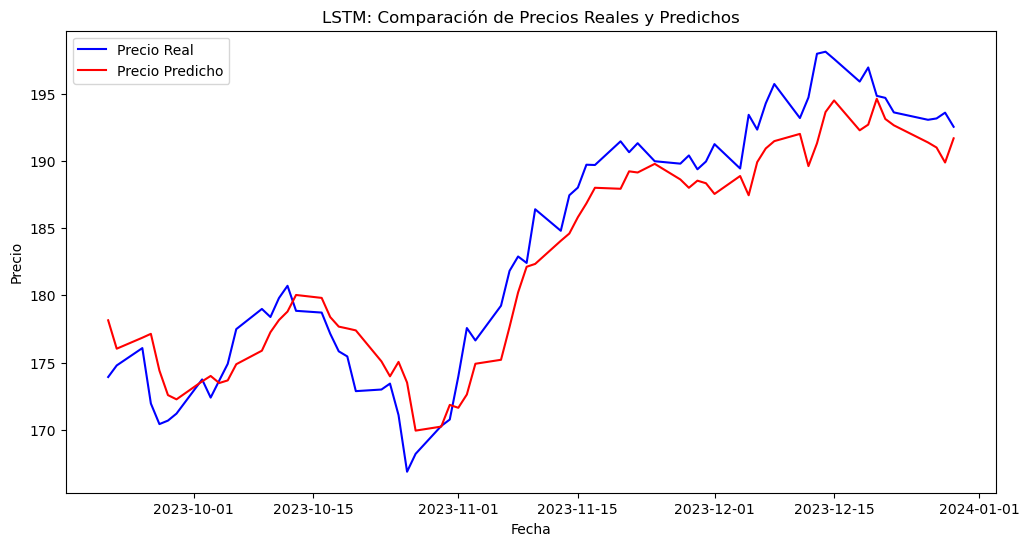

In [29]:

# Crear una figura para el gráfico
plt.figure(figsize=(12, 6))

# Graficar los precios reales
plt.plot(result_df['Close'], label='Precio Real', color='blue')

# Graficar los precios predichos
plt.plot(result_df['Predicted_Close'], label='Precio Predicho', color='red')

# Añadir título y etiquetas
plt.title('LSTM: Comparación de Precios Reales y Predichos')
plt.xlabel('Fecha')
plt.ylabel('Precio')

# Añadir leyenda
plt.legend()

# Mostrar el gráfico
plt.show()


## Model architecture overview

In [30]:
tf.keras.utils.plot_model(
    model,
    to_file="Transformer+TimeEmbedding.png",
    show_shapes=True,
    show_layer_names=True,
    expand_nested=True,
    dpi=96,)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.
